In [1]:
import numpy as np
import pandas as pd

Firstly, we need to load our data, notice that there is no column names in csv files and thus header shold be set to `None`.

In [2]:
train = pd.read_csv('emnist-balanced-train.csv', header=None)
test = pd.read_csv('emnist-balanced-test.csv', header=None)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now split labels and images from original dataframe.

In [3]:
train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

One hot encoding with `get_dummies()` and you can compare it with the original labels.

In [4]:
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
train_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Turn our Dataframes into numpy array and delete `train` and `test` to save up memory.

In [5]:
train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values
del train, test

For some reason, sadly, the EMNIST dataset was rotated and flipped and we need fix that.

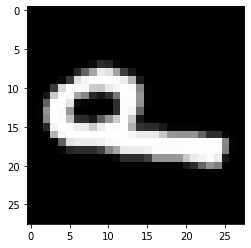

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_data[45].reshape([28, 28]), cmap='Greys_r')
plt.show()

In [7]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

In [8]:
from scipy import ndimage, misc

def rotate10(image):
    img_45 = ndimage.rotate(image.reshape([28,28]), -15, reshape=False)
#plt.imshow(img_45, cmap='Greys_r')
    img_45=img_45.reshape(1,784)
    img_45=img_45.ravel()
    img_45.reshape(28,28)
    return img_45
train_data1 = np.apply_along_axis(rotate10, 1, train_data)
test_data1 = np.apply_along_axis(rotate10, 1, test_data)
#plt.imshow(img_45.reshape(28,28), cmap='Greys_r')


In [9]:
train_d=np.concatenate((train_data,train_data1))
test_d=np.concatenate((test_data,test_data1))

train_l=np.concatenate((train_labels,train_labels))
test_l=np.concatenate((test_labels,test_labels))

In [10]:
train_l.shape[0]

225600

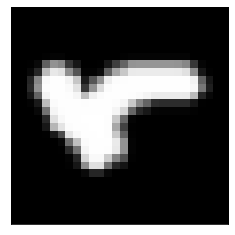

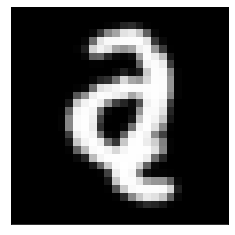

In [11]:
for i in range(2):
    path="sample"+str(i)+".png"
    fig=plt.imshow(train_data[i].reshape([28, 28]), cmap='Greys_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.savefig(path,bbox_inches='tight',pad_inches=0)
    plt.show()

Now let's import tensorflow to start building our network, with slim we can keep our code neat.

In [12]:
import tensorflow as tf

In [13]:
tf.reset_default_graph()
xs = tf.placeholder(tf.float32, [None, 784], name='input')
ys = tf.placeholder(tf.float32, [None, 47], name='exp_output')
dropout = tf.placeholder(tf.float32, name='dropout')

In [14]:
 # define the computation graph
x_image = tf.reshape(xs, [-1, 28, 28, 1])
layer = tf.layers.conv2d(x_image, 64, [5,5], padding='same', activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
layer = tf.layers.max_pooling2d(layer, pool_size=(2,2), strides=2) # [-1, 14, 14, 64]
layer = tf.layers.batch_normalization(layer)
layer = tf.layers.conv2d(layer, 128, [2,2], padding='same', activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
layer = tf.layers.max_pooling2d(layer, pool_size=(2,2), strides=2) # [-1, 7, 7, 128]
x_flat = tf.reshape(layer, [-1, 7*7*128])
flatten = tf.layers.dense(x_flat, 1024, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
flatten = tf.nn.dropout(flatten, keep_prob=1-dropout)
flatten = tf.layers.dense(flatten, 512, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
flatten = tf.layers.batch_normalization(flatten)
flatten = tf.layers.dense(flatten, 128, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
flatten = tf.layers.dense(flatten, 47)
pred = tf.nn.softmax(flatten, name='output')
    

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now define our loss function, in this case, it is `softmax_cross_entropy_with_logits` but the official document shows it is deprecated as labels will be affected in backprop. But we use placeholders to feed data, and this is will not be a problem for us. In order to get rid of the warn info and keep our notebook neat, I use the `_v2` version. For more information on these two functions, you can refer to [StackExchange](https://stats.stackexchange.com/questions/327348/how-is-softmax-cross-entropy-with-logits-different-from-softmax-cross-entropy-wi)

In [15]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=ys,
    logits=flatten))

In [16]:
train = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
correct = tf.equal(tf.argmax(flatten, 1), tf.argmax(ys, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()

In [ ]:
NUM = 112800
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(20):
        for i in range(int(NUM / 100)):
            x_batches, y_batches = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            sess.run(train, feed_dict={xs: x_batches, ys: y_batches, dropout: 0.5})
            
            if i % 1000 == 0:
                acc, entropy = sess.run([accuracy, cross_entropy], feed_dict={xs: test_data,
                                                    ys: test_labels,
                                                    dropout: 0})
                print('Train Entropy : ', sess.run(cross_entropy, feed_dict={xs: x_batches, ys: y_batches, dropout: 0.5}))
                print('Test Accr & Entropy : ', acc, entropy)
                # save_and_generate_proto(sess)
    acc = sess.run(accuracy, feed_dict={xs: test_data,
                                                ys: test_labels,
                                                dropout: 0})
    print(acc)

The final accuracy of our network is about 88.27%.  We are using the same balanced dataset and achieved these results. We have normalized the input pixels by dividing them with 255, hence a boost in accuracy was achieved from 85 to 88%. We have also used batch norms to tackle with the problem of covarient shifts. From our training results we conclude that the model has high varience, it is evident from the fact that training loss got down to 0.15 and testing loss was 3 times more than training loss. With this we conclude either our model was overfitting or that train data is not enough. Since we have used dropouts, overfitting is not an issue, The issue is the dataset, We can gather more training data and that should possibly solve the problem of high varience.